In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [31]:
county_tree_df = pd.read_csv("county_tree_temp_dwp_prcp_KT.csv", index_col=False)
county_tree_df = county_tree_df[(county_tree_df != 0).all(1)]
county_tree_df["Biomass"] = county_tree_df["Biomass"]/county_tree_df["number_trees"]
county_tree_df["Biomass"] = county_tree_df["Biomass"]/county_tree_df["number_trees"]
len(county_tree_df)

32611

In [56]:
state_code = pd.read_csv("County_State_Codes.csv")
# state_code = county_tree_df["state_code"].unique()
# state_code
state_name = state_code.loc[state_code.state_code==13]["state_name"].unique()[0]
state_name

'Georgia'

In [33]:
county_1 = county_tree_df[(county_tree_df["state_code"]==13)]
sweetgum_county1 = county_1.loc[county_1.species == 'sweetgum']
sweetgum_county1["Biomass"] = sweetgum_county1["Biomass"]/sweetgum_county1["number_trees"]
sweetgum_county1["Biomass"] = sweetgum_county1["Biomass"]/sweetgum_county1["number_trees"]
sweetgum_county1 = sweetgum_county1.drop(["state_code", "county_code", "species", 'number_trees', "latitude",
                                         "longitude"], axis = 1)
sweetgum_county1 = sweetgum_county1[(sweetgum_county1 != 0).all(1)]

sweetgum_county1.head()

/Users/neutrino/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/neutrino/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,year,volume,Biomass,mean_temp,mean_dwp,mean_prcp
465,2001,15.792353,4.479686,65.689565,56.242899,0.062957
473,2001,151.147326,10.333200,66.141944,55.357500,0.088444
475,2001,194.842520,0.018223,63.341091,51.786138,0.124928
478,2001,106.398674,1.638437,60.816409,48.896616,0.084200
481,2001,178.535011,0.036132,63.373259,52.320891,0.129610


In [34]:
sweetgum_county1_avg = sweetgum_county1.groupby("year").mean()
sweetgum_county1_avg = sweetgum_county1_avg.reset_index()


## Some diagnostic plots

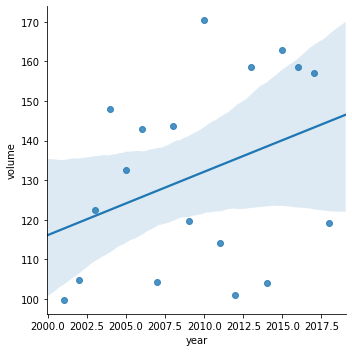

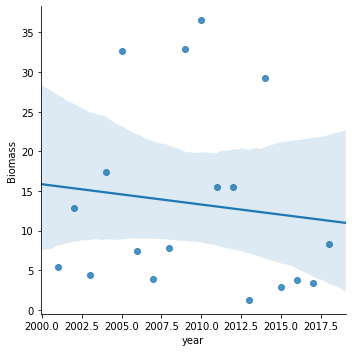

In [35]:
sns.lmplot(data =sweetgum_county1_avg, x='year', y = 'volume' , logx=True)
sns.lmplot(data =sweetgum_county1_avg, x='year', y = 'Biomass' , logx=True)

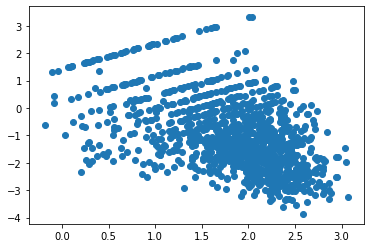

In [36]:
plt.scatter(np.log10(sweetgum_county1.volume),np.log10(sweetgum_county1.Biomass))
# plt.yscale('log')
# plt.xscale('log')
# sns.lmplot(data =sweetgum_county1, x='Biomass', y = 'volume')


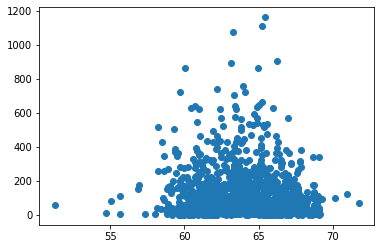

In [37]:
plt.scatter(sweetgum_county1.mean_temp,sweetgum_county1.volume)
# plt.scatter(sweetgum_county1.mean_dwp,sweetgum_county1.Biomass)
# plt.yscale('log')
# plt.xscale('log')

(1, 10000.0)

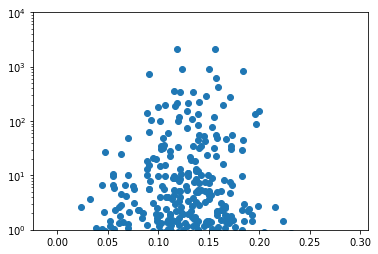

In [40]:
plt.scatter(sweetgum_county1.mean_prcp,sweetgum_county1.Biomass)
# plt.scatter(county_tree_df.loc[(county_tree_df.species == "sweetgum") & (county_tree_df["state_code"]==13)].mean_prcp,county_tree_df.loc[(county_tree_df.species == "sweetgum") & (county_tree_df["state_code"]==13)].Biomass)

plt.yscale('log')
plt.ylim(1,1E4)
# len(county_tree_df.loc[(county_tree_df.species == "sweetgum") & (county_tree_df["state_code"]==13)].mean_prcp)
# len(sweetgum_county1.mean_prcp)

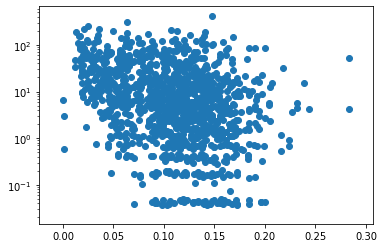

In [57]:
plt.scatter(sweetgum_county1.mean_prcp,sweetgum_county1.volume/sweetgum_county1.Biomass)
plt.yscale('log')


## Loop over species

In [85]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import QuantileTransformer, quantile_transform



In [86]:
species = county_tree_df.species.unique()
species

array(['loblolly pine', 'red maple', 'sweetgum', 'yellow-poplar',
       'slash pine'], dtype=object)

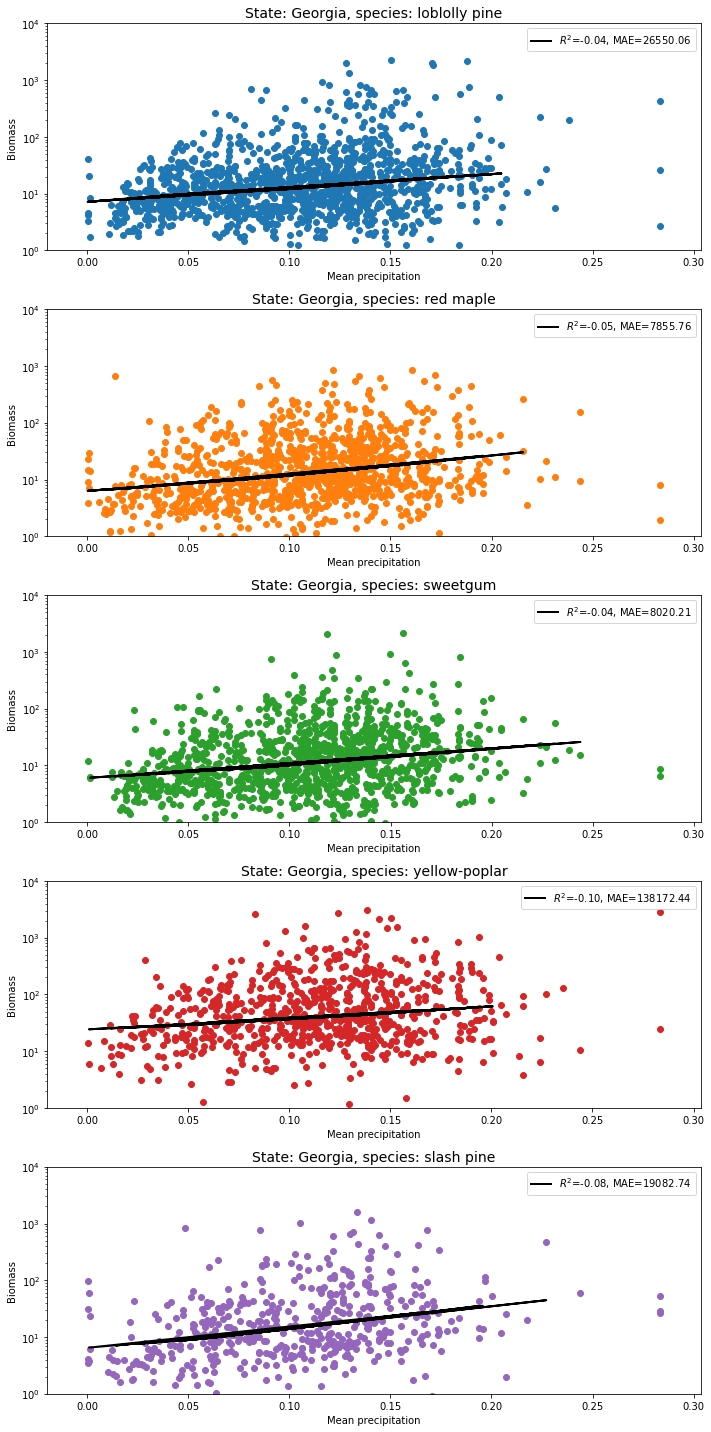

In [110]:
j=0
fig, axs = plt.subplots(5, figsize=(10,20))
for specie in species:
    X = county_tree_df.loc[(county_tree_df.species == specie) & (county_tree_df["state_code"]==13)].mean_prcp.values.reshape(-1,1)
    y = county_tree_df.loc[(county_tree_df.species == specie) & (county_tree_df["state_code"]==13)].Biomass.values.reshape(-1,1)
    y_trans = quantile_transform(y,
                             n_quantiles=300,
                             output_distribution='normal',
                             copy=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
    axs[j].set_title("State: %s, species: %s"%(state_name,specie), fontsize=14)
    axs[j].scatter(X,y, c="C%i"%j)
#     regr = linear_model.LinearRegression()
    regr_trans.fit(X_train,y_train)
    y_pred = regr_trans.predict(X_test)
    axs[j].plot(X_test, y_pred, color='k', linewidth=2, label=r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)))
    axs[j].set_yscale('log')
    axs[j].legend()
    axs[j].set_ylim(1,1E4)
    j=j+1
for ax in axs.flat:
    ax.set(xlabel='Mean precipitation', ylabel='Biomass')
plt.tight_layout()
plt.savefig("/Users/neutrino/Downloads/top5_species_reg_transformation.png", dpi=200)